In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [2]:
warnings.filterwarnings(action="ignore",
                        message="^internal gelsd")
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})
pd.set_option("display.max_rows",
              None, 
              "display.max_columns",
              None)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [3]:
def axes_log_conversion (list_of_values):
    list_num = []
    for i in list_of_values:
        list_num.append(str(int(round(((-10**(-i) + 1) * 100),0))) + '%')
    return list_num

In [4]:
df = pd.read_csv('../data/object-detection-on-coco.csv',
                 usecols=['name',
                          'year',
                          'flops',
                          'multiadds',
                          'hardware_burden',
                          'network_operations',
                           '(BOX AP)'])[3:].reset_index(drop=True)

In [5]:
df = df.astype({'flops': 'float64',
                'multiadds': 'float64',
                'hardware_burden': 'float64',
                'network_operations': 'float64',
                '(BOX AP)': 'float64'})

df['ops_forward_pass'] = df['flops'].combine_first(df['multiadds'] * 2)
df['box_ap_percent'] = df['(BOX AP)'].astype(float)/100

df = df[['name', 
         'year',
         'box_ap_percent',
         'ops_forward_pass', 
         'network_operations', 
         'hardware_burden']]

In [6]:
df.head(10)

,name,year,box_ap_percent,ops_forward_pass,network_operations,hardware_burden
0,Florence-CoSwin-H,2021,0.624,NaN,NaN,8.620000e+21
1,"CPNDet (Hourglass-104, multi-scale)",2020,0.492,NaN,NaN,8.790000e+19
2,"CenterNet-HG (Hourglass-104, multi-scale)",2019,0.451,NaN,NaN,5.150000e+19
3,SaccadeNet (DLA-34-DCN),2020,0.385,NaN,NaN,4.650000e+19
4,"M2Det (VGG-16, multi-scale)",2018,0.442,NaN,NaN,3.420000e+19
5,"InterNet (ResNet-101-FPN, multi-scale)",2019,0.442,NaN,NaN,2.580000e+19
6,RetinaMask (ResNeXt-101-FPN-GN),2019,0.426,NaN,NaN,1.220000e+19
7,MultiPath Network,2016,0.332,NaN,NaN,1.140000e+19
8,Mask R-CNN (ResNeXt-101-FPN),2018,0.398,NaN,NaN,8.670000e+18
9,SNIPER (ResNet-101),2018,0.461,NaN,NaN,5.700000e+18


## Operations Per Forward Pass

In [7]:
error__ops_forward_pass__poly = ols('I(np.log10(box_ap_percent)) ~ I(np.log10(ops_forward_pass))', data=df).fit()
print(error__ops_forward_pass__poly.summary()) 

                                 OLS Regression Results                                
Dep. Variable:     I(np.log10(box_ap_percent))   R-squared:                       0.676
Model:                                     OLS   Adj. R-squared:                  0.649
Method:                          Least Squares   F-statistic:                     25.09
Date:                         Thu, 04 Aug 2022   Prob (F-statistic):           0.000305
Time:                                 15:58:29   Log-Likelihood:                 18.469
No. Observations:                           14   AIC:                            -32.94
Df Residuals:                               12   BIC:                            -31.66
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


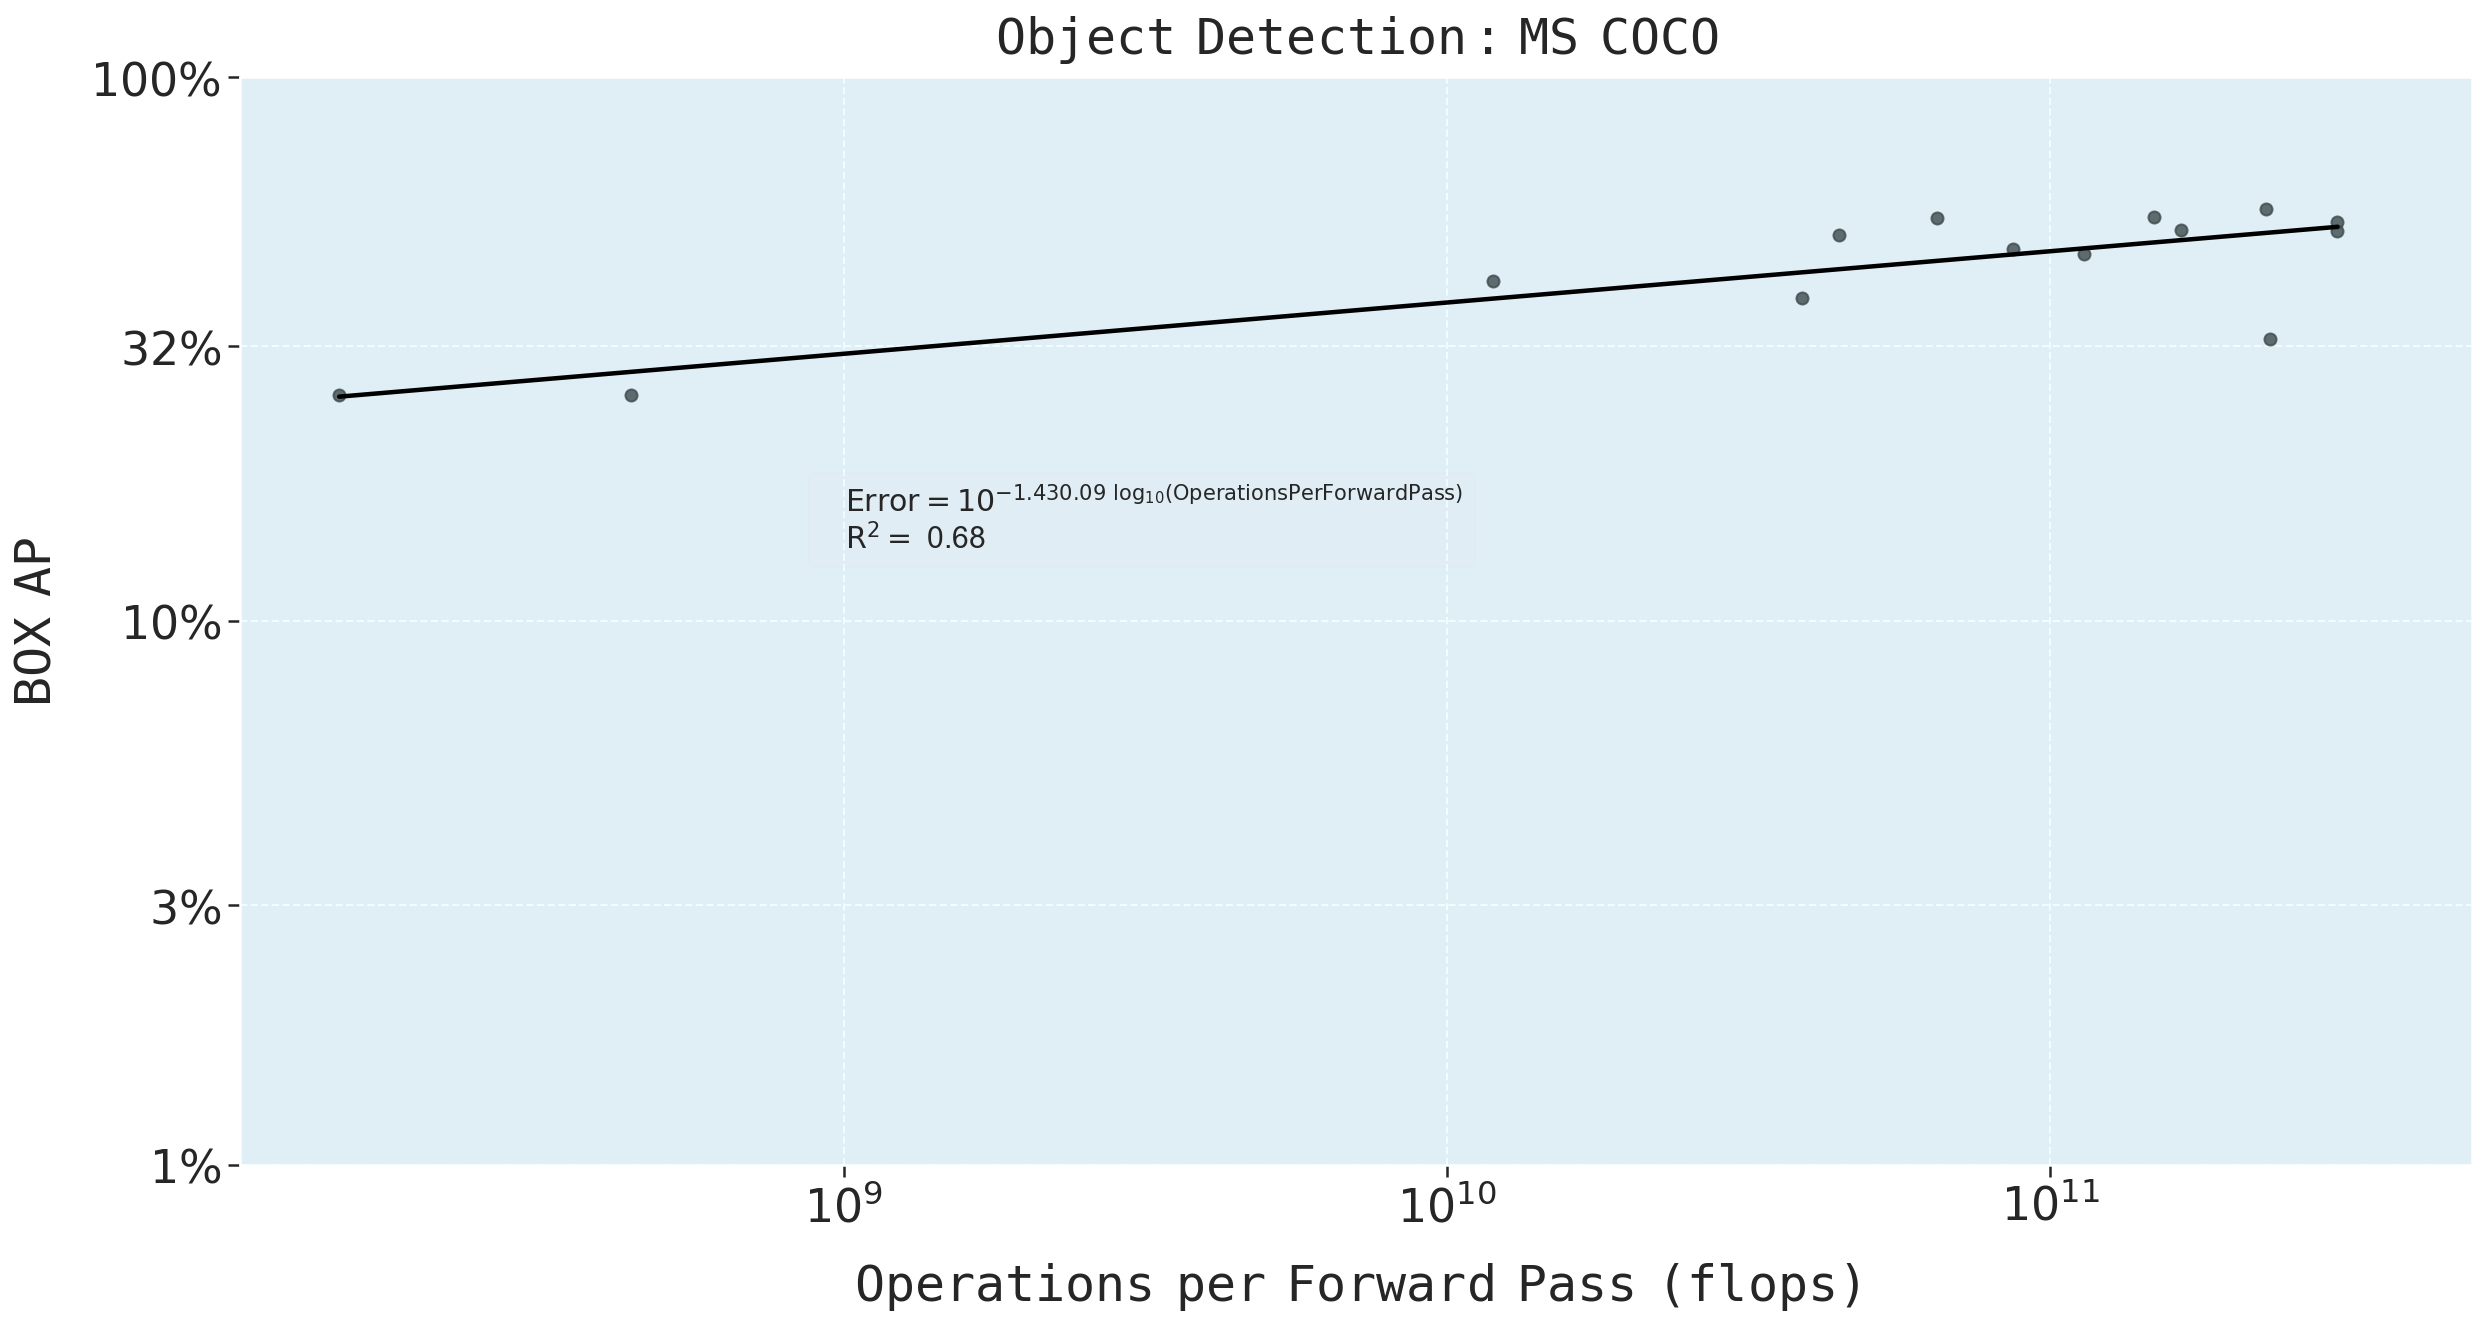

In [8]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['ops_forward_pass']),
            y=np.log10(df['box_ap_percent']),
            color='black',
            ci = False,
            label=r'$\mathrm{Error}= 10^{' +
                  str(round(error__ops_forward_pass__poly.params[0],2)) +
                  str(round(error__ops_forward_pass__poly.params[1],2)) +
                  '\ \mathrm{log_{10}(OperationsPerForwardPass)} }$' + '\n' + 
                  r'$\mathrm{R^{2}}=\ $' +
                  str(round(error__ops_forward_pass__poly.rsquared,2)))

plt.title('$\mathtt{Object\ \ Detection:\ MS\ \ COCO}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{BOX\ \ AP}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Operations\ \ per\ \ Forward\ \ Pass \ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.56,.65),
           handlelength=0,
           framealpha =.03,
           fontsize=15,
           markerscale=0)

plt.axhspan(-2, -0, 
            color="#c9f9ff",
            alpha=0.3)

x = np.arange(9.8,12,1)

y = [np.log10(0.01), 
     np.log10(0.03),
     np.log10(0.1), 
     np.log10(0.32), 
     np.log10(1)]

x_label = ['$10^{9}$',
           '$10^{10}$',
           '$10^{11}$']

y_label = ['$1\%$',
           '$3\%$',
           '$10\%$',
           '$32\%$',
           '$100\%$']

plt.xlim(8.8, 12.5)

plt.ylim(-2, -0)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

## Hardware Burden

In [9]:
acc__hw_burden__poly = ols('I((np.log10(1/(1-box_ap_percent)))) ~ I(np.log10(hardware_burden))',data=df).fit()
print(acc__hw_burden__poly.summary()) 

                                       OLS Regression Results                                      
Dep. Variable:     I((np.log10(1 / (1 - box_ap_percent))))   R-squared:                       0.776
Model:                                                 OLS   Adj. R-squared:                  0.756
Method:                                      Least Squares   F-statistic:                     38.13
Date:                                     Thu, 04 Aug 2022   Prob (F-statistic):           6.96e-05
Time:                                             15:58:30   Log-Likelihood:                 27.820
No. Observations:                                       13   AIC:                            -51.64
Df Residuals:                                           11   BIC:                            -50.51
Df Model:                                                1                                         
Covariance Type:                                 nonrobust                                         


/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


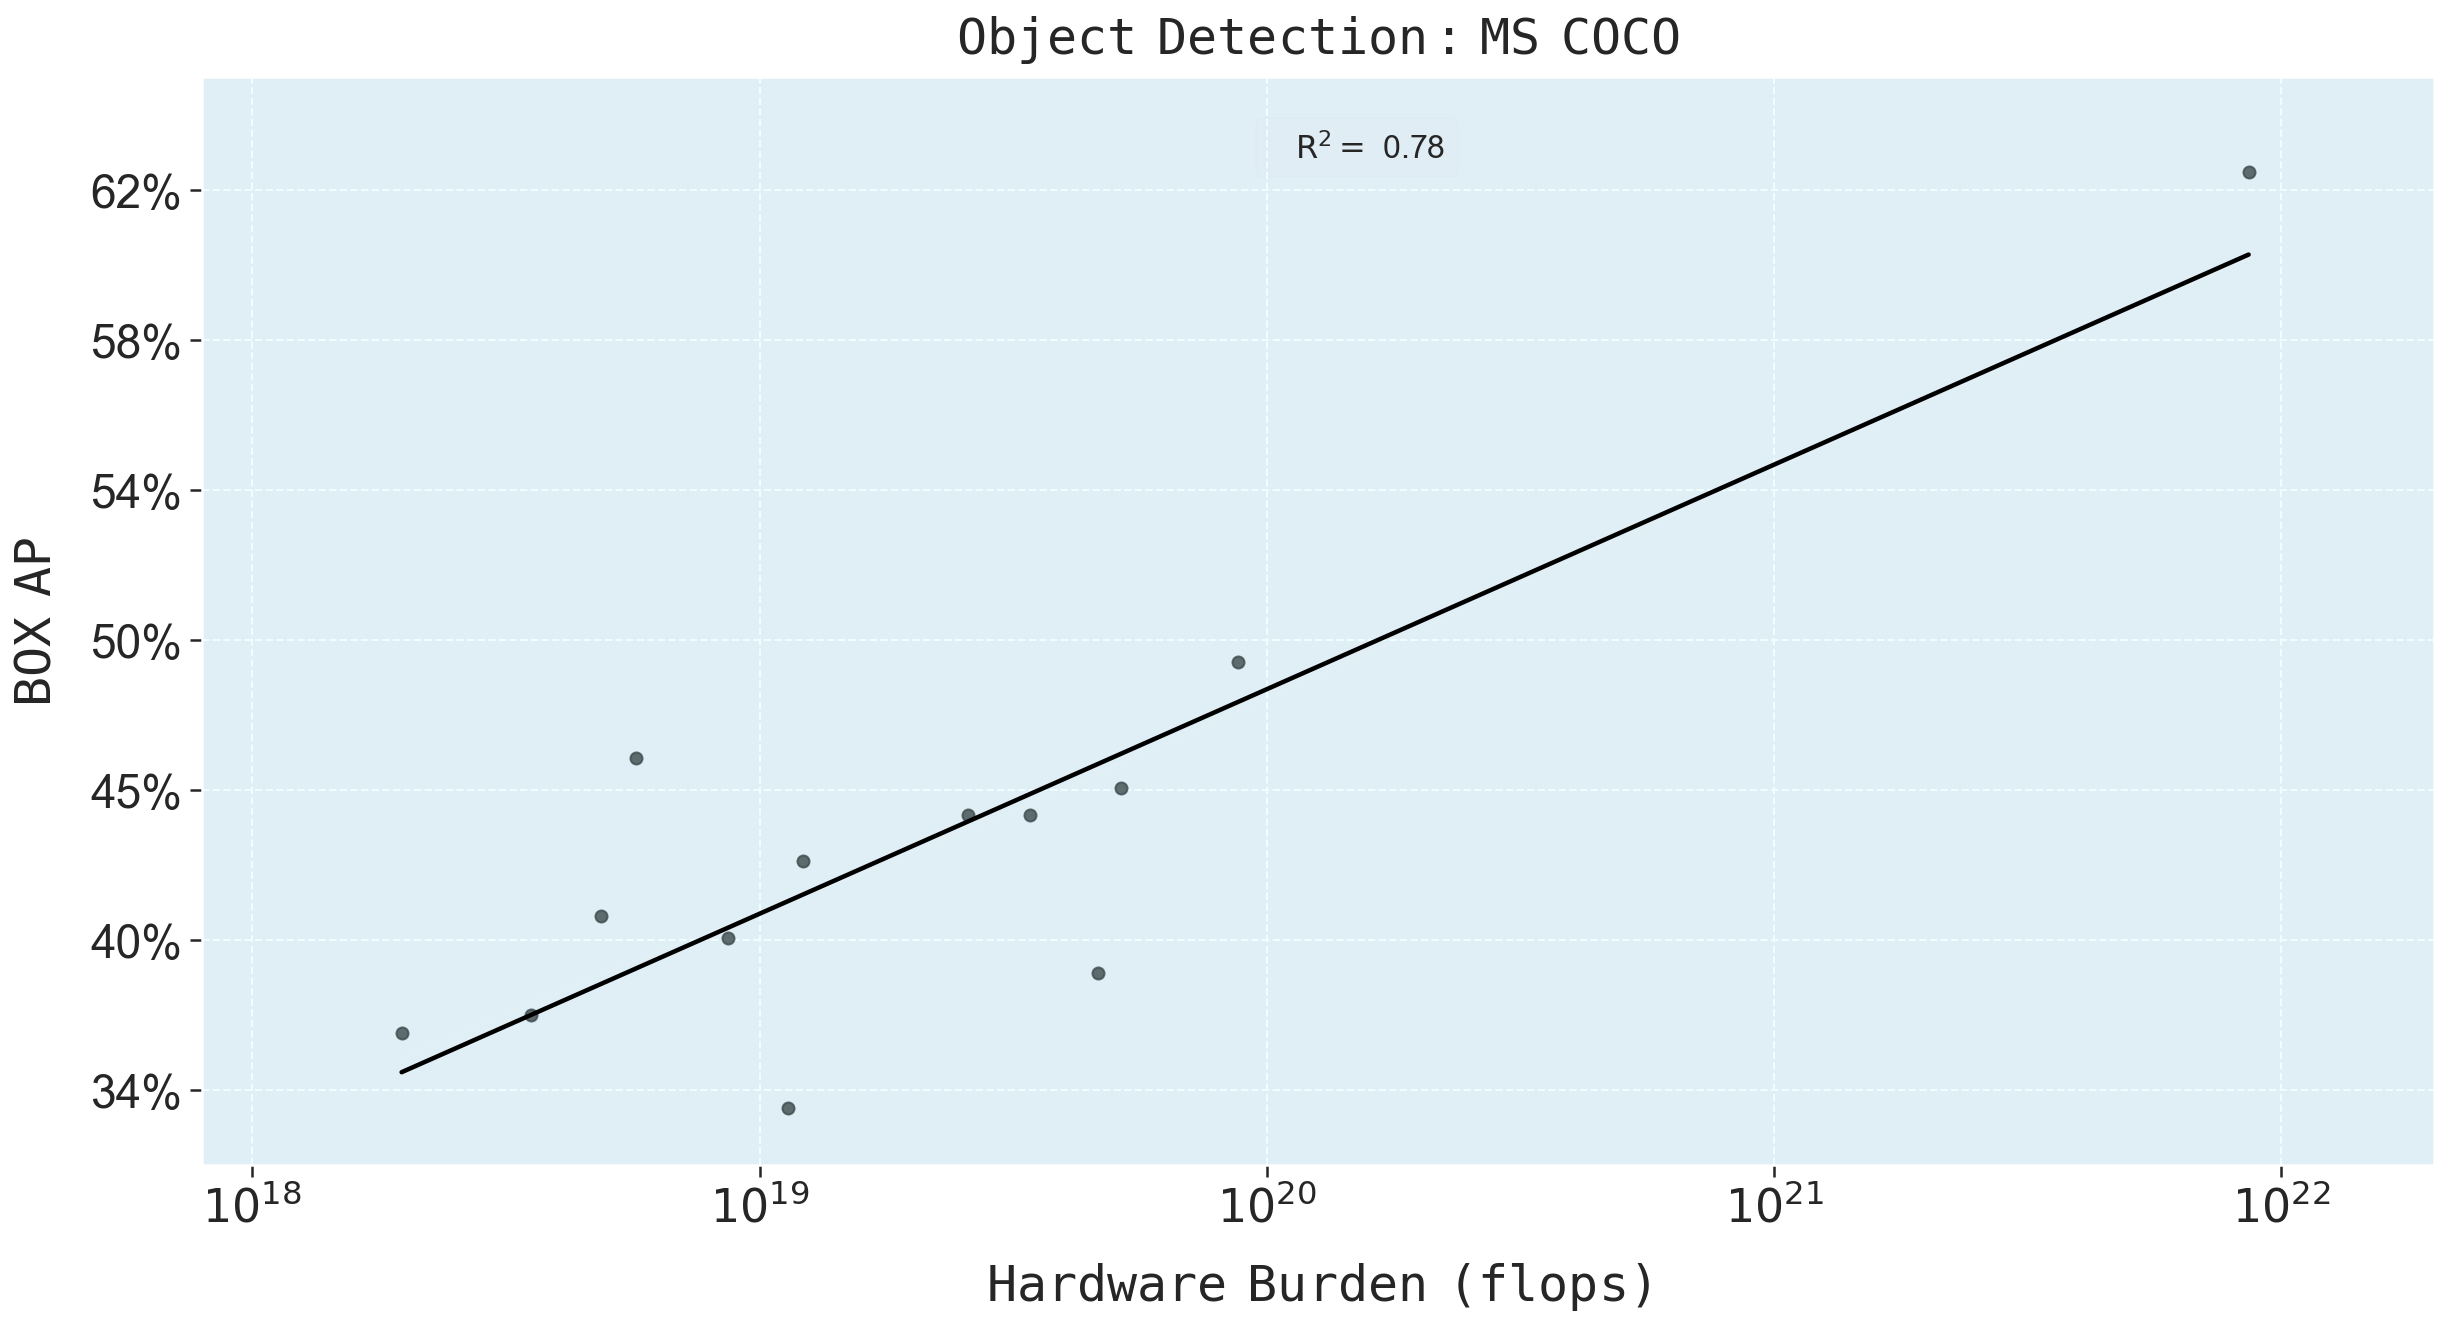

In [10]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['hardware_burden']),
            y=np.log10(1/(1-df['box_ap_percent'])),
            color='black',
            ci = False,
            label=r'$\mathrm{R^{2}}=\ $' +
            str(round(acc__hw_burden__poly.rsquared,2)))


plt.title('$\mathtt{Object\ \ Detection:\ MS\ \ COCO}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{BOX\ \ AP}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Hardware\ \ Burden\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.57,.977),
           handlelength=0,
           framealpha =.03,
           fontsize=16,
           markerscale=0)

plt.axhspan(.16, .45,
            color="#c9f9ff",
            alpha=0.3)

x = np.arange(18,23,1)

y = np.arange(.18,.45,.04)

x_label = ['$10^{18}$',
           '$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$']

y_label = axes_log_conversion(y)

plt.ylim(.16, .45)

plt.xlim(17.9, 22.3)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

## Network Operations

In [11]:
acc__network_ops__poly = ols('I((np.log10(1/(1-box_ap_percent)))) ~ I(np.log10(network_operations))',data=df).fit()
print(acc__network_ops__poly.summary()) 

                                       OLS Regression Results                                      
Dep. Variable:     I((np.log10(1 / (1 - box_ap_percent))))   R-squared:                       0.860
Model:                                                 OLS   Adj. R-squared:                  0.831
Method:                                      Least Squares   F-statistic:                     30.59
Date:                                     Thu, 04 Aug 2022   Prob (F-statistic):            0.00265
Time:                                             15:58:30   Log-Likelihood:                 15.031
No. Observations:                                        7   AIC:                            -26.06
Df Residuals:                                            5   BIC:                            -26.17
Df Model:                                                1                                         
Covariance Type:                                 nonrobust                                         


/opt/homebrew/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


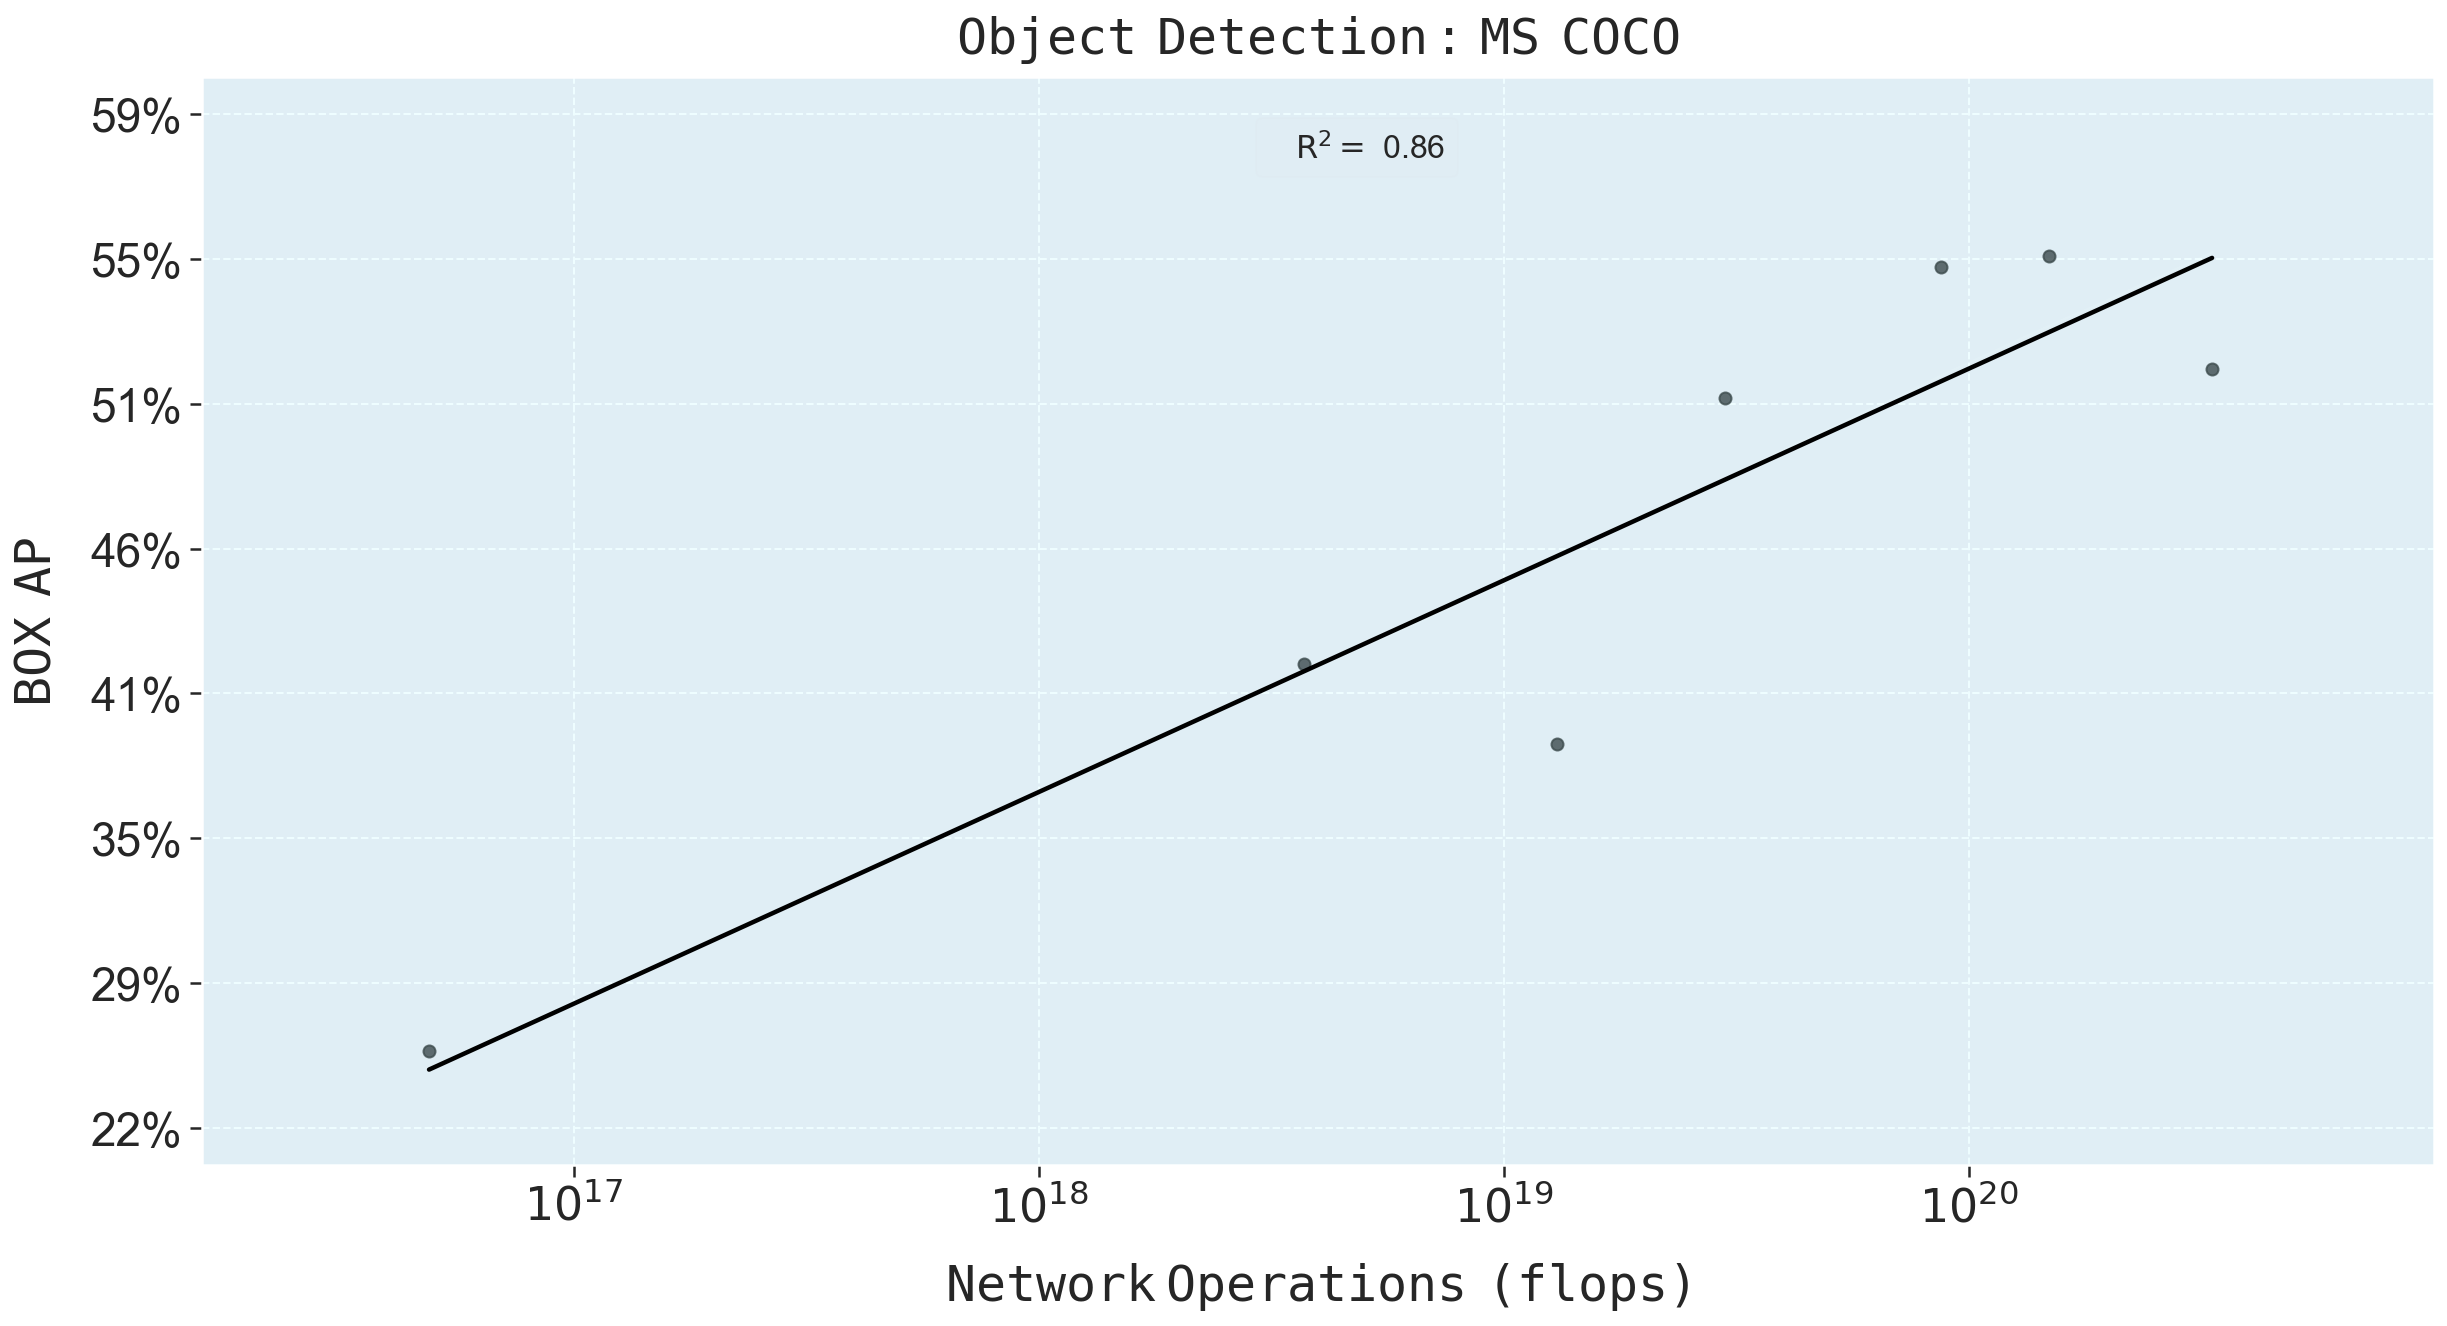

In [12]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['network_operations']),
            y=np.log10(1/(1-df['box_ap_percent'])),
            color='black',
            ci = False,
            label=r'$\mathrm{R^{2}}=\ $' +
            str(round(acc__network_ops__poly.rsquared,2)))

plt.title('$\mathtt{Object\ \ Detection:\ MS\ \ COCO}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{BOX\ \ AP}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Network\ Operations\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.57,.977),
           handlelength=0,
           framealpha =.03,
           fontsize=16,
           markerscale=0)

plt.axhspan(.1, .4,
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(17,21,1)

y = np.arange(.11,.4,.04)

x_label = ['$10^{17}$',
           '$10^{18}$',
           '$10^{19}$',
           '$10^{20}$']

y_label = axes_log_conversion(y)

plt.xlim(16.2, 21)

plt.ylim(.1, .4)

plt.xticks(x, x_label, size=23)

plt.yticks(y, y_label, size=23)

plt.show()

## Conversion Regression: Network Operations into Hardware Burden (from ImageNet)

In [13]:
df['hardware_burden_pred'] = 10**(2.7580 + 0.8935 * np.log10(df['network_operations']))
df['hardware_burden_consolidated'] = df["hardware_burden"].combine_first(df["hardware_burden_pred"])

### Hardware Burden (Consolidated)

In [14]:
acc__hw_burden__pred__poly = ols('I(np.log10(1/(1-box_ap_percent))) ~ I(np.log10(hardware_burden_consolidated))',data=df).fit()
print(acc__hw_burden__pred__poly.summary()) 

                                      OLS Regression Results                                     
Dep. Variable:     I(np.log10(1 / (1 - box_ap_percent)))   R-squared:                       0.814
Model:                                               OLS   Adj. R-squared:                  0.804
Method:                                    Least Squares   F-statistic:                     78.92
Date:                                   Thu, 04 Aug 2022   Prob (F-statistic):           5.35e-08
Time:                                           15:58:30   Log-Likelihood:                 42.510
No. Observations:                                     20   AIC:                            -81.02
Df Residuals:                                         18   BIC:                            -79.03
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

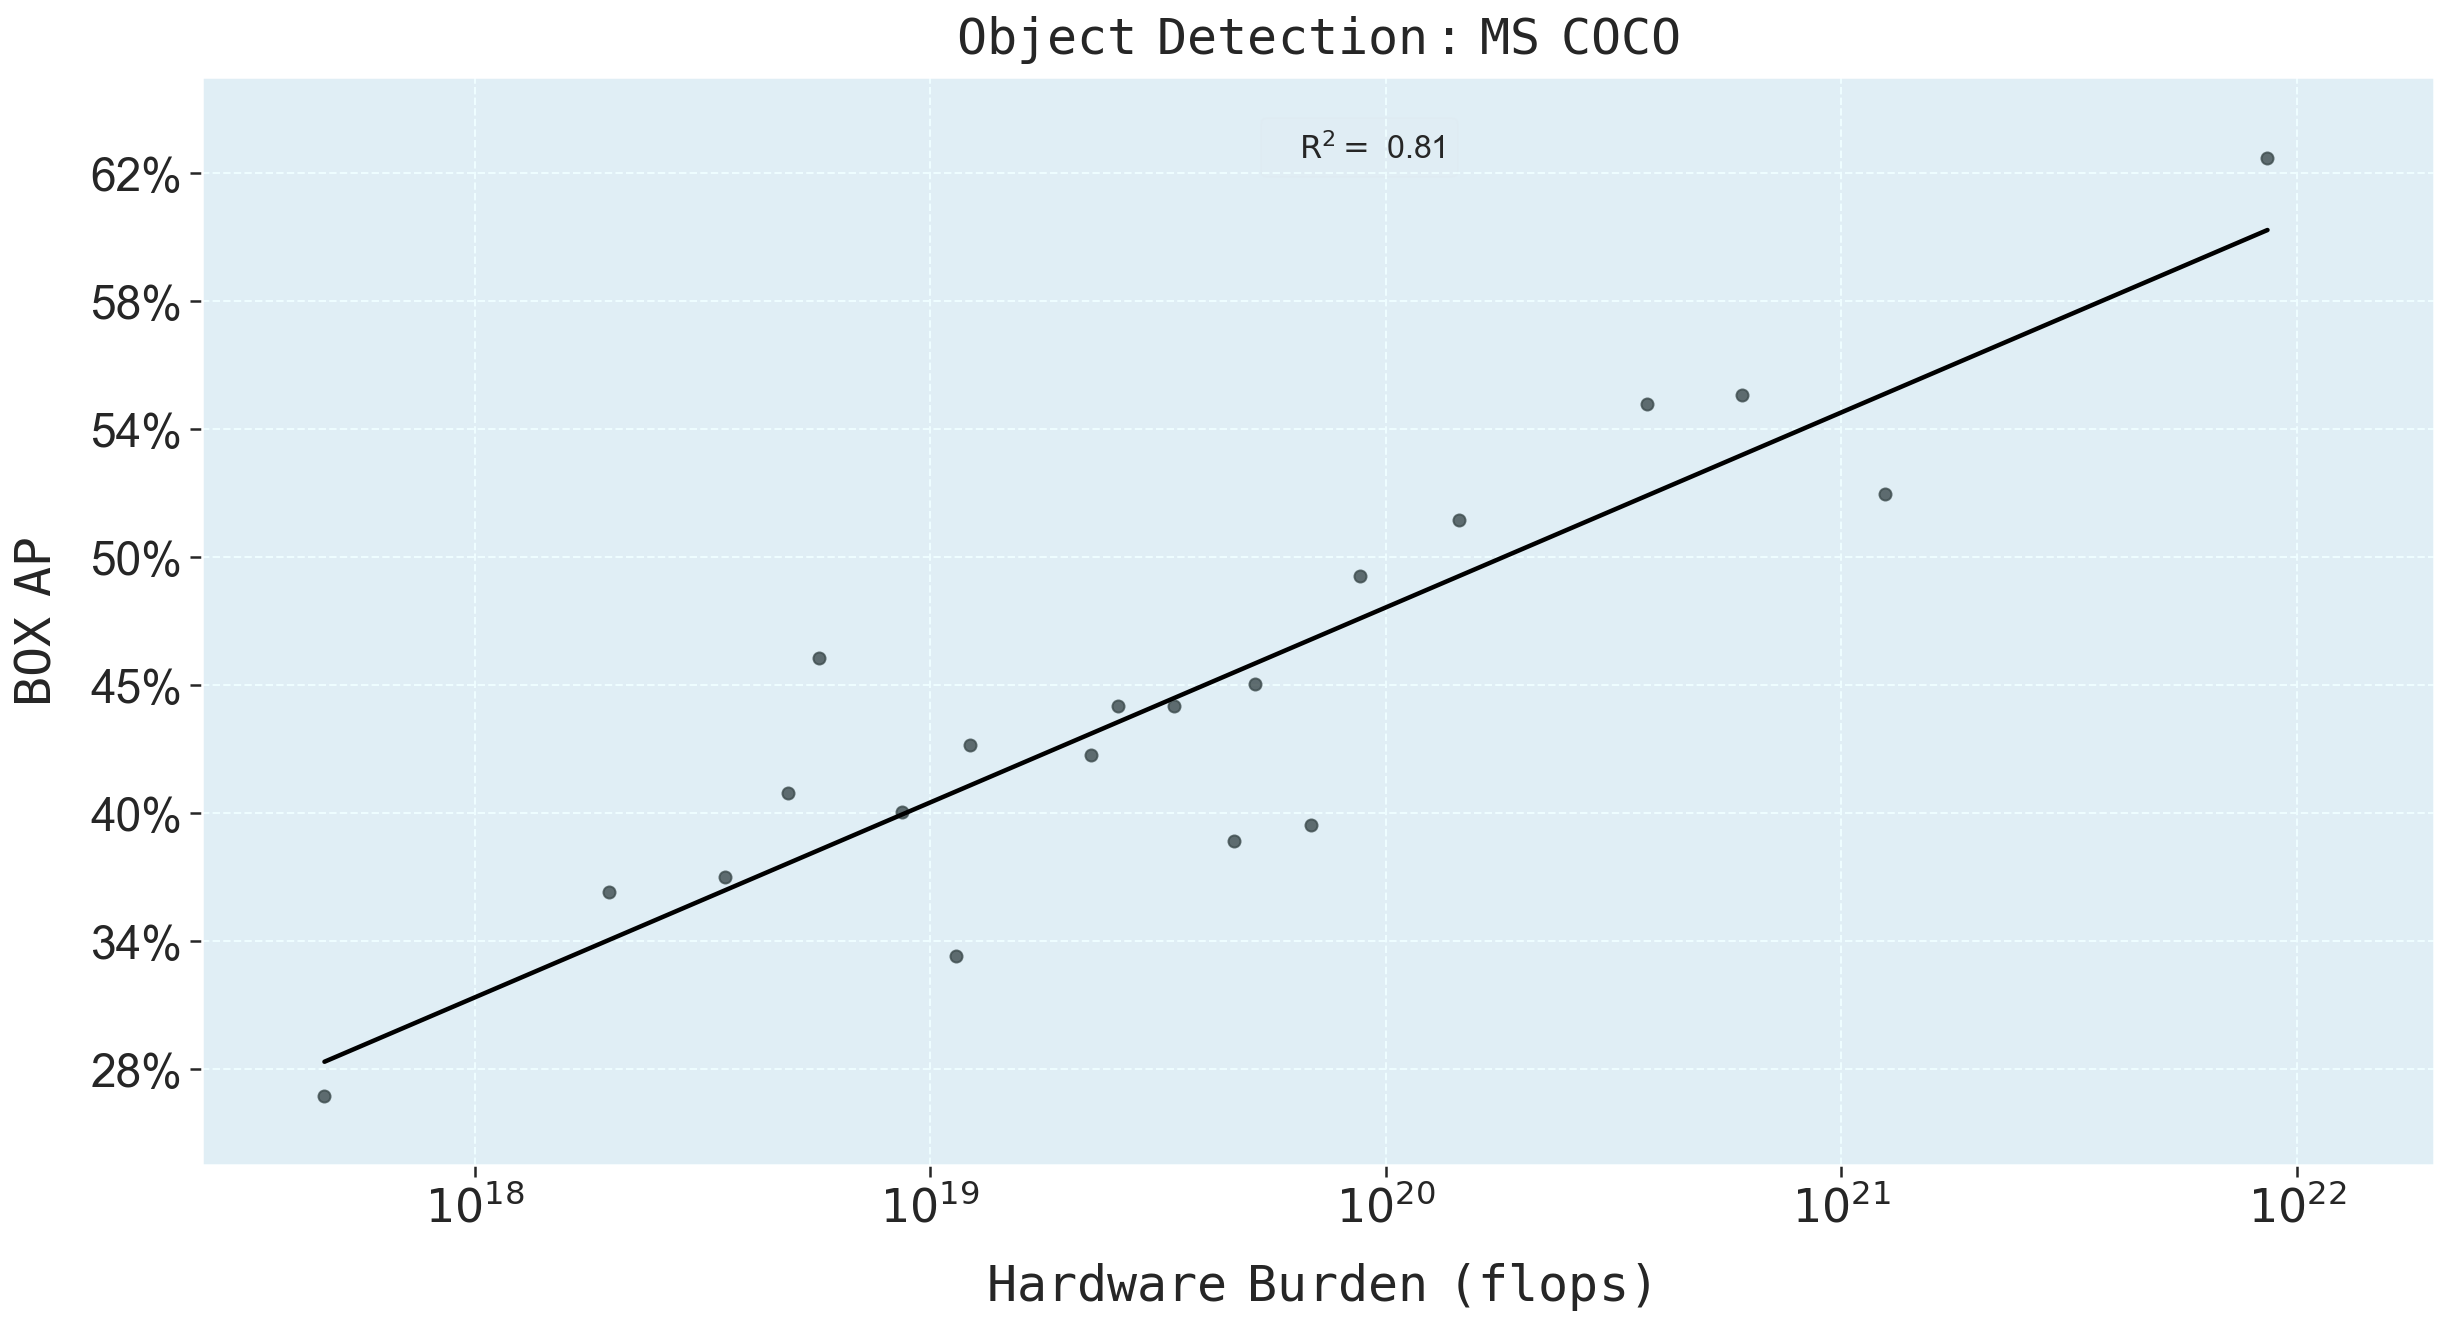

In [15]:
fig = plt.figure(figsize=(20, 10))

sns.regplot(x=np.log10(df['hardware_burden_consolidated']),
            y=np.log10(1/(1-df['box_ap_percent'])),
            color='black',
            ci = False,
            label=r'$\mathrm{R^{2}}=\ $' +
            str(round(acc__hw_burden__pred__poly.rsquared,2)))

plt.title('$\mathtt{Object\ \ Detection:\ MS\ \ COCO}$',
          fontsize=25,
          weight='bold',
          pad=12)

plt.ylabel("$\mathtt{BOX\ \ AP}$",
           fontsize=25,
           labelpad=15,
           weight='bold')

plt.xlabel("$\mathtt{Hardware\ \ Burden\ \ (flops)}$",
           fontsize=25,
           labelpad=15,
           rotation=0,
           y=.975,
           weight='bold')

plt.legend(bbox_to_anchor=(.57,.977),
           handlelength=0,
           framealpha =.03,
           fontsize=16,
           markerscale=0)

plt.axhspan(.11, .45,
            color="#c9f9ff", 
            alpha=0.3)

x = np.arange(18,23,1)

y = np.arange(.14,.45,.04)

x_label = ['$10^{18}$',
           '$10^{19}$',
           '$10^{20}$',
           '$10^{21}$',
           '$10^{22}$']

y_label = axes_log_conversion(y)

plt.ylim(.11, .45)

plt.xlim(17.4, 22.3)

plt.yticks(y, y_label, size=23)

plt.xticks(x, x_label, size=23)

plt.show()

In [16]:
acc__hw_burden__pred__exp = ols('I((1/(1-box_ap_percent))) ~ I(np.log10(hardware_burden_consolidated))',data=df).fit()
print(acc__hw_burden__pred__exp.summary()) 

                                  OLS Regression Results                                 
Dep. Variable:     I((1 / (1 - box_ap_percent)))   R-squared:                       0.814
Model:                                       OLS   Adj. R-squared:                  0.803
Method:                            Least Squares   F-statistic:                     78.55
Date:                           Thu, 04 Aug 2022   Prob (F-statistic):           5.53e-08
Time:                                   15:58:31   Log-Likelihood:                 12.700
No. Observations:                             20   AIC:                            -21.40
Df Residuals:                                 18   BIC:                            -19.41
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025   